In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

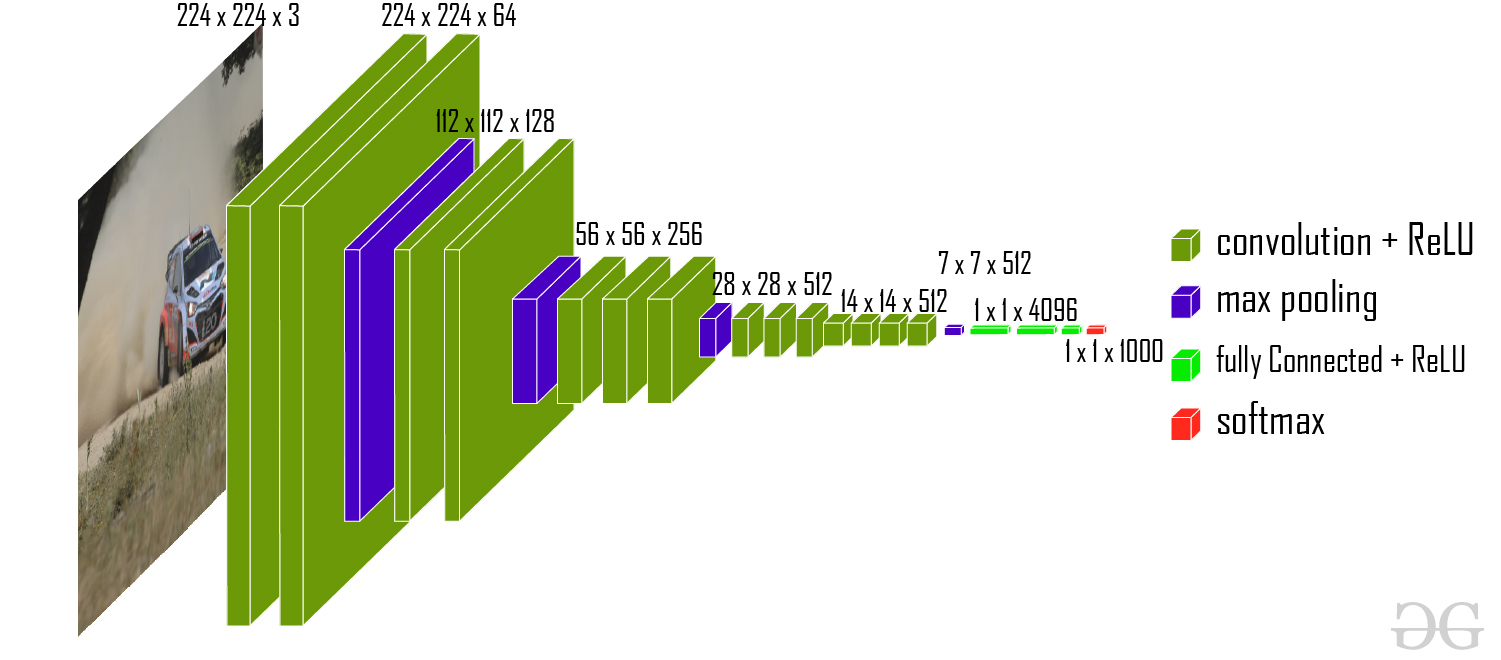

In [ ]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M",],
    "VGG19": [64,64,"M",128,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512,"M"]
}


In [2]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M",],
    "VGG19": [64,64,"M",128,128,"M",256,256,256,256,"M",512,512,512,512,"M",512,512,512,512,"M"]
}

class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG16"])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        #nn.Sequential takes as argument the layers separated as a sequence of arguments or an OrderedDict, so use * .
        return nn.Sequential(*layers)

In [3]:
model=VGG_net().to(device)
print(model)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),